In [1]:
# install cell
%cd /content
!/usr/local/cuda/bin/nvcc --version
!git clone https://github.com/shreyas-bk/U-2-Net
%cd /content/U-2-Net
print('making images directory')
!mkdir images
print('making results directory')
!mkdir results
print('importing...')
from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2
from google.colab.patches import cv2_imshow
import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import glob
from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset
from model import U2NET
from model import U2NETP
!pip install pytorch2keras
print('Done!')

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
fatal: destination path 'U-2-Net' already exists and is not an empty directory.
/content/U-2-Net
making images directory
mkdir: cannot create directory ‘images’: File exists
making results directory
mkdir: cannot create directory ‘results’: File exists
importing...
Done!


In [2]:
# upload cell
%cd /content/U-2-Net/images
uploaded = files.upload()
%cd /content/U-2-Net

/content/U-2-Net/images


Saving U_2_NETP_IMAGE2.jpg to U_2_NETP_IMAGE2.jpg
/content/U-2-Net


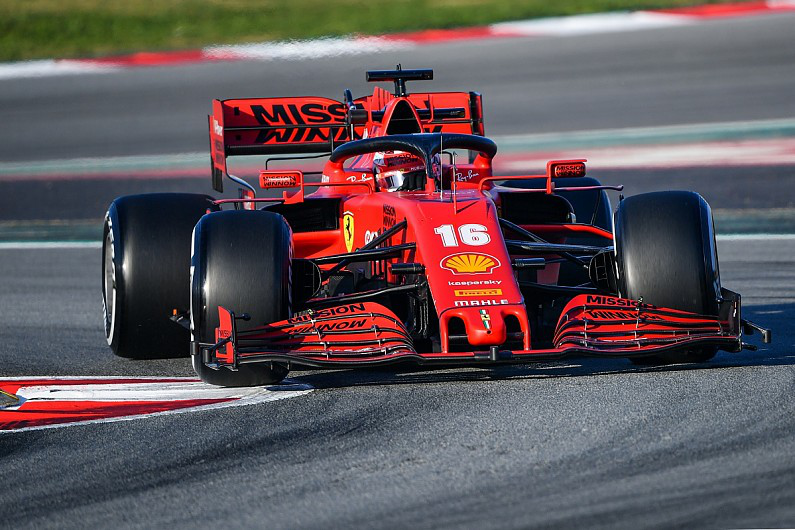

In [3]:
# display cell
img = Image.open('/content/U-2-Net/images/U_2_NETP_IMAGE2.jpg')
display(img)

In [4]:
# modification cell
# change upsample mode from bilinear to nearest for conversion to keras
model_file = open(r'/content/U-2-Net/model/u2net.py', 'r')
model_lines = model_file.readlines()
model_lines[23] = "    src = F.upsample(src,size=tar.shape[2:],mode='nearest')\n"
model_file.close()
model_file = open(r'/content/U-2-Net/model/u2net.py', 'w')
model_file.writelines(model_lines)
model_file.close()

In [ ]:
# NOTE: MIGHT NEED TO RESTART THE NOTEBOOK (RUNTIME->RESTART RUNTIME)
# FOLLOWING THIS, RUN THE INSTALL CELL ONCE AGAIN, THEN RUN THE REST OF THE CELLS BELOW

In [2]:
# setup cell
# create sample input
image_dir = os.path.join(os.getcwd(), 'images')
img_name_list = glob.glob(image_dir + os.sep + '*')
test_salobj_dataset = SalObjDataset(img_name_list = img_name_list, lbl_name_list = [], transform=transforms.Compose([RescaleT(320), ToTensorLab(flag=0)]))
test_salobj_dataloader = DataLoader(test_salobj_dataset, batch_size=1, shuffle=False, num_workers=1)
for i_test, data_test in enumerate(test_salobj_dataloader):
    inputs_test = data_test['image']
    inputs_test = inputs_test.type(torch.FloatTensor)
    if torch.cuda.is_available():
        inputs_test = Variable(inputs_test.cuda())
        print('Created tensor of size:',inputs_test.shape)
# load pytorch model
model_name='u2netp'# change to u2net if required
prediction_dir = os.path.join(os.getcwd(), 'results/')
model_dir = os.path.join(os.getcwd(), model_name + '.pth')
net = U2NETP(3,1)
net.load_state_dict(torch.load('/content/U-2-Net/u2netp.pth'))
if torch.cuda.is_available():
  net.cuda()
print('PyTorch Model loaded')

Created tensor of size: torch.Size([1, 3, 320, 320])
PyTorch Model loaded


In [ ]:
# conversion cell
from pytorch2keras.converter import pytorch_to_keras
u2netp_keras = pytorch_to_keras(net, inputs_test, [(3, 320, 320,)], verbose=True, change_ordering=False)

['/content/U-2-Net/images/U_2_NETP_IMAGE2.jpg']
inferencing: U_2_NETP_IMAGE2.jpg


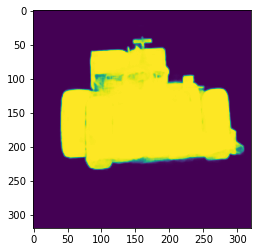

In [13]:
# inference cell
# adapted from u2net_test.py
import matplotlib.pyplot as plt
def normPRED(d):
    ma = np.max(d)
    mi = np.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

def save_output(image_name,pred,d_dir):

    predict = pred
    predict_np = predict.squeeze()
    
    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    imo.save(d_dir+imidx+'.png')

def main():

    # --------- 1. get image path and name ---------
    model_name='u2netp'# fixed as u2netp

    image_dir = os.path.join(os.getcwd(), 'images') # changed to 'images' directory which is populated while running the script
    prediction_dir = os.path.join(os.getcwd(), 'results/') # changed to 'results' directory which is populated after the predictions
    model_dir = os.path.join(os.getcwd(), model_name + '.pth') # path to u2netp pretrained weights

    img_name_list = glob.glob(image_dir + os.sep + '*')
    print(img_name_list)

    # --------- 2. dataloader ---------
    #1. dataloader
    test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                        lbl_name_list = [],
                                        transform=transforms.Compose([RescaleT(320),
                                                                      ToTensorLab(flag=0)])
                                        )
    test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)

    # --------- 3. model define ---------
    net = U2NETP(3,1)
    net.load_state_dict(torch.load(model_dir))
    if torch.cuda.is_available():
        net.cuda()
    net.eval()

    # --------- 4. inference for each image ---------
    for i_test, data_test in enumerate(test_salobj_dataloader):

        print("inferencing:",img_name_list[i_test].split(os.sep)[-1])

        inputs_test = np.array(data_test['image'])
        d1,d2,d3,d4,d5,d6,d7 = u2netp_keras.predict(inputs_test) # USING THE KERAS MODEL HERE

        # normalization
        pred = np.array(d1[:,0,:,:])
        pred = normPRED(pred[0])
        plt.imshow(pred)
        plt.plot()
        plt.show()
        # save results to test_results folder
        if not os.path.exists(prediction_dir):
            os.makedirs(prediction_dir, exist_ok=True)
        save_output(img_name_list[i_test],pred,prediction_dir)

        del d1,d2,d3,d4,d5,d6,d7

if __name__ == "__main__":
    main()


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 38032



INPUT                                 BACKGROUND REMOVED             BOUNDING BOX                         SALIENT MAP



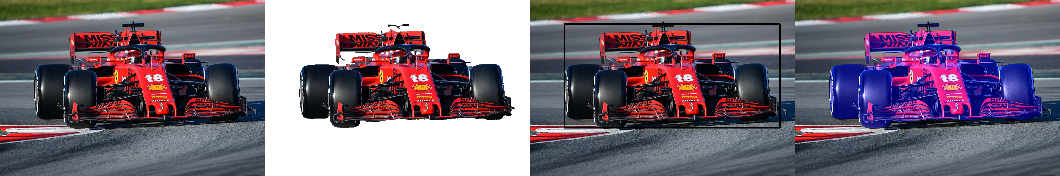

In [14]:
# test cell
# adapted from my repo
image_dir = os.path.join(os.getcwd(), 'images')
names = [name[:-4] for name in os.listdir(image_dir)]
THRESHOLD = 0.9
RESCALE = 255
LAYER = 2
COLOR = (0, 0, 0)
THICKNESS = 4
SAL_SHIFT = 100


for name in names:

  # BACKGROUND REMOVAL

  if name == '.ipynb_checkpo':
    continue
  output = load_img('/content/U-2-Net/results/'+name+'.png')
  out_img = img_to_array(output)
  out_img /= RESCALE

  out_img[out_img > THRESHOLD] = 1
  out_img[out_img <= THRESHOLD] = 0

  shape = out_img.shape
  a_layer_init = np.ones(shape = (shape[0],shape[1],1))
  mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
  a_layer = mul_layer*a_layer_init
  rgba_out = np.append(out_img,a_layer,axis=2)

  input = load_img('/content/U-2-Net/images/'+name+'.jpg')
  inp_img = img_to_array(input)
  inp_img /= RESCALE

  a_layer = np.ones(shape = (shape[0],shape[1],1))
  rgba_inp = np.append(inp_img,a_layer,axis=2)

  rem_back = (rgba_inp*rgba_out)
  rem_back_scaled = rem_back*RESCALE

  # BOUNDING BOX CREATION

  out_layer = out_img[:,:,LAYER]
  x_starts = [np.where(out_layer[i]==1)[0][0] if len(np.where(out_layer[i]==1)[0])!=0 else out_layer.shape[0]+1 for i in range(out_layer.shape[0])]
  x_ends = [np.where(out_layer[i]==1)[0][-1] if len(np.where(out_layer[i]==1)[0])!=0 else 0 for i in range(out_layer.shape[0])]
  y_starts = [np.where(out_layer.T[i]==1)[0][0] if len(np.where(out_layer.T[i]==1)[0])!=0 else out_layer.T.shape[0]+1 for i in range(out_layer.T.shape[0])]
  y_ends = [np.where(out_layer.T[i]==1)[0][-1] if len(np.where(out_layer.T[i]==1)[0])!=0 else 0 for i in range(out_layer.T.shape[0])]
  
  startx = min(x_starts)
  endx = max(x_ends)
  starty = min(y_starts)
  endy = max(y_ends)
  start = (startx,starty)
  end = (endx,endy)

  box_img = inp_img.copy()
  box_img = cv2.rectangle(box_img, start, end, COLOR, THICKNESS)
  box_img = np.append(box_img,a_layer,axis=2)
  box_img_scaled = box_img*RESCALE

  # SALIENT FEATURE MAP

  sal_img = inp_img.copy()
  add_layer = out_img.copy()
  add_layer[add_layer==1] = SAL_SHIFT/RESCALE
  sal_img[:,:,LAYER] += add_layer[:,:,LAYER]
  sal_img = np.append(sal_img,a_layer,axis=2)
  sal_img_scaled = sal_img*RESCALE
  sal_img_scaled[sal_img_scaled>RESCALE] = RESCALE

  # OUTPUT RESULTS

  inp_img*=RESCALE
  inp_img = np.append(inp_img,RESCALE*a_layer,axis=2)
  inp_img = cv2.resize(inp_img,(int(shape[1]/3),int(shape[0]/3)))
  rem_back = cv2.resize(rem_back_scaled,(int(shape[1]/3),int(shape[0]/3)))
  box_img = cv2.resize(box_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  sal_img = cv2.resize(sal_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  result = np.concatenate((inp_img,rem_back,box_img,sal_img),axis=1)
  result_img = Img.fromarray(result.astype('uint8'), 'RGBA')
  print('\nINPUT                                 BACKGROUND REMOVED             BOUNDING BOX                         SALIENT MAP\n')
  display(result_img)

In [15]:
# save cell
u2netp_keras.save('/content/u2netp_keras.h5')

In [16]:
# example load cell
from keras.models import load_model
loaded_model = load_model('/content/u2netp_keras.h5', compile=False)